keras: https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c

torch:
https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

1. weights - data patterns extracted from the images.
2. Different Conv2D filters are created for each of the three channels for a color image.

In [1]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib                          import pyplot
from matplotlib.image                    import imread
from torchvision.datasets                import ImageFolder
from torch.optim.lr_scheduler            import OneCycleLR
from sklearn.metrics                     import r2_score


import numpy                  as np
import matplotlib.pyplot      as plt
import matplotlib.image       as mpimg
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchinfo
from torchvision              import datasets
import torch
import os
import random
import matplotlib
import torchvision
import torchinfo
import gc 
import os
import time


In [13]:
oTransforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
                                # transforms.Normalize(mean=0., std=1.)]

In [4]:
DATA_PATH           = "/home/ubadmin/Lectures/OrYair/Datasets/PetImages/PetImages"
oDataSet            = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=oTransforms)
N                   = len(oDataSet)
nTrain              = 22500
nTest               = 2498
oTrainSet, oTestSet = torch.utils.data.random_split(oDataSet, [nTrain, nTest], generator=torch.Generator().manual_seed(42))

In [80]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

In [81]:
images, labels = next(iter(oTrainDL))
images.shape

torch.Size([256, 3, 224, 224])

/home/ubadmin/venv38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/ubadmin/venv38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


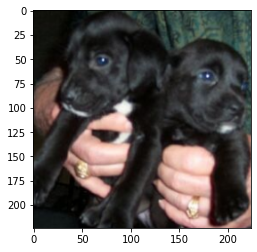

In [7]:
plt.imshow(np.transpose(images[0].numpy(), (1,2,0)))

In [82]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(), #-- does nothing
        
        nn.Conv2d(3,   16,  3, bias=False, stride=2), nn.BatchNorm2d(16),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(16,  32,  3, bias=False, stride=2), nn.BatchNorm2d(32),  nn.ReLU(), nn.Dropout2d(0.1),
        nn.Conv2d(32,  64,  3, bias=False, stride=2), nn.BatchNorm2d(64),  nn.ReLU(), nn.Dropout2d(0.1),        
        nn.Conv2d(64,  128,  3, bias=False, stride=2), nn.BatchNorm2d(128),  nn.ReLU(), nn.Dropout2d(0.1),        
        nn.Conv2d(128,  256,  3, bias=False, stride=2), nn.BatchNorm2d(256),  nn.ReLU(), nn.Dropout2d(0.1),        
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),     
        nn.Linear           (256, 64),
        nn.Linear           (64, 2),        
    )
    
    return oModel

torchinfo.summary(GetModel(), (batchSize, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [256, 2]                  --
├─Identity: 1-1                          [256, 3, 224, 224]        --
├─Conv2d: 1-2                            [256, 16, 111, 111]       432
├─BatchNorm2d: 1-3                       [256, 16, 111, 111]       32
├─ReLU: 1-4                              [256, 16, 111, 111]       --
├─Dropout2d: 1-5                         [256, 16, 111, 111]       --
├─Conv2d: 1-6                            [256, 32, 55, 55]         4,608
├─BatchNorm2d: 1-7                       [256, 32, 55, 55]         64
├─ReLU: 1-8                              [256, 32, 55, 55]         --
├─Dropout2d: 1-9                         [256, 32, 55, 55]         --
├─Conv2d: 1-10                           [256, 64, 27, 27]         18,432
├─BatchNorm2d: 1-11                      [256, 64, 27, 27]         128
├─ReLU: 1-12                             [256, 64, 27, 27]         --
├─Drop

In [83]:
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [84]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
                
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)                        
            loss = Loss(mZ, vY)           
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)                
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [85]:
def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, Epoch=Epoch, sModelName='BestParams'):

    vTrainLoss   = np.full(nEpochs, np.nan)
    vTrainMetric = np.full(nEpochs, np.nan)
    vValLoss     = np.full(nEpochs, np.nan)
    vValMetric   = np.full(nEpochs, np.nan)
    vLR          = np.full(0,       np.nan)
    bestMetric   = -float('inf')

    for epoch in range(nEpochs):
        startTime                    = time.time()
        trainLoss, trainMetric, vLRi = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valMetric,   _    = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime                    = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch       :03d}:',   end='')
        print(' | Train loss: '   f'{trainLoss   :6.3f}',   end='')
        print(' | Val loss: '     f'{valLoss     :6.3f}',   end='')
        print(' | Train Metric: ' f'{trainMetric :6.3f}',   end='')
        print(' | Val Metric: '   f'{valMetric   :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime   :6.3f} |', end='')

        vTrainLoss  [epoch] = trainLoss
        vTrainMetric[epoch] = trainMetric
        vValLoss    [epoch] = valLoss
        vValMetric  [epoch] = valMetric
        vLR                 = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return vTrainLoss, vTrainMetric, vValLoss, vValMetric, vLR

In [86]:
nEpochs    = 50
DEVICE     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
nIter      = nEpochs * len(oTrainDL)
Loss       = nn.CrossEntropyLoss()
Metric     = Accuracy
oModel     = GetModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, 
                        oOptim, oScheduler, Epoch=Epoch, sModelName='CNN-1')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.658 | Val loss:  0.641 | Train Metric:  0.602 | Val Metric:  0.612 | epoch time: 36.336 | <-- Checkpoint!
Epoch 001: | Train loss:  0.622 | Val loss:  0.551 | Train Metric:  0.656 | Val Metric:  0.723 | epoch time: 36.002 | <-- Checkpoint!
Epoch 002: | Train loss:  0.597 | Val loss:  0.586 | Train Metric:  0.681 | Val Metric:  0.687 | epoch time: 35.835 |
Epoch 003: | Train loss:  0.573 | Val loss:  0.547 | Train Metric:  0.704 | Val Metric:  0.735 | epoch time: 38.096 | <-- Checkpoint!
Epoch 004: | Train loss:  0.564 | Val loss:  0.568 | Train Metric:  0.713 | Val Metric:  0.707 | epoch time: 36.506 |
Epoch 005: | Train loss:  0.541 | Val loss:  0.576 | Train Metric:  0.729 | Val Metric:  0.691 | epoch time: 36.168 |
Epoch 006: | Train loss:  0.530 | Val loss:  0.561 | Train Metric:  0.735 | Val Metric:  0.713 | epoch time: 38.139 |
Epoch

KeyboardInterrupt: 

# feature maps

In [87]:
model_weights   = []
conv_layers     = []
model_children  = list(oModel.children())

counter = 0

for i in range(len(model_children)):
    
    if type(model_children[i]) == nn.Conv2d:
        
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.  append(model_children[i])
        
print(f"Total convolution layers: {counter}")

Total convolution layers: 5


In [88]:
conv_layers

[Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), bias=False),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)]

In [89]:
images, labels = next(iter(oTestDL))

RuntimeError: DataLoader worker (pid(s) 8167, 8179) exited unexpectedly

In [ ]:
idx = random.randint(0,batchSize)
image = np.transpose(images[idx])
plt.imshow(image)
print(f"{image.shape}, {type(image)}")

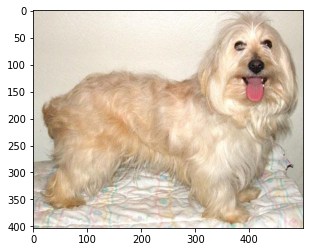

In [90]:
from PIL import Image
image = Image.open(str('/home/ubadmin/Lectures/OrYair/Datasets/PetImages/PetImages/Dog/23.jpg'))
plt.imshow(image)

In [91]:
image = oTransforms(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(DEVICE)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [92]:
outputs = []
names   = []

for layer in conv_layers[0:]:
    image = layer(image)
    
    outputs.append(image)
    names.  append(str(layer))

In [93]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

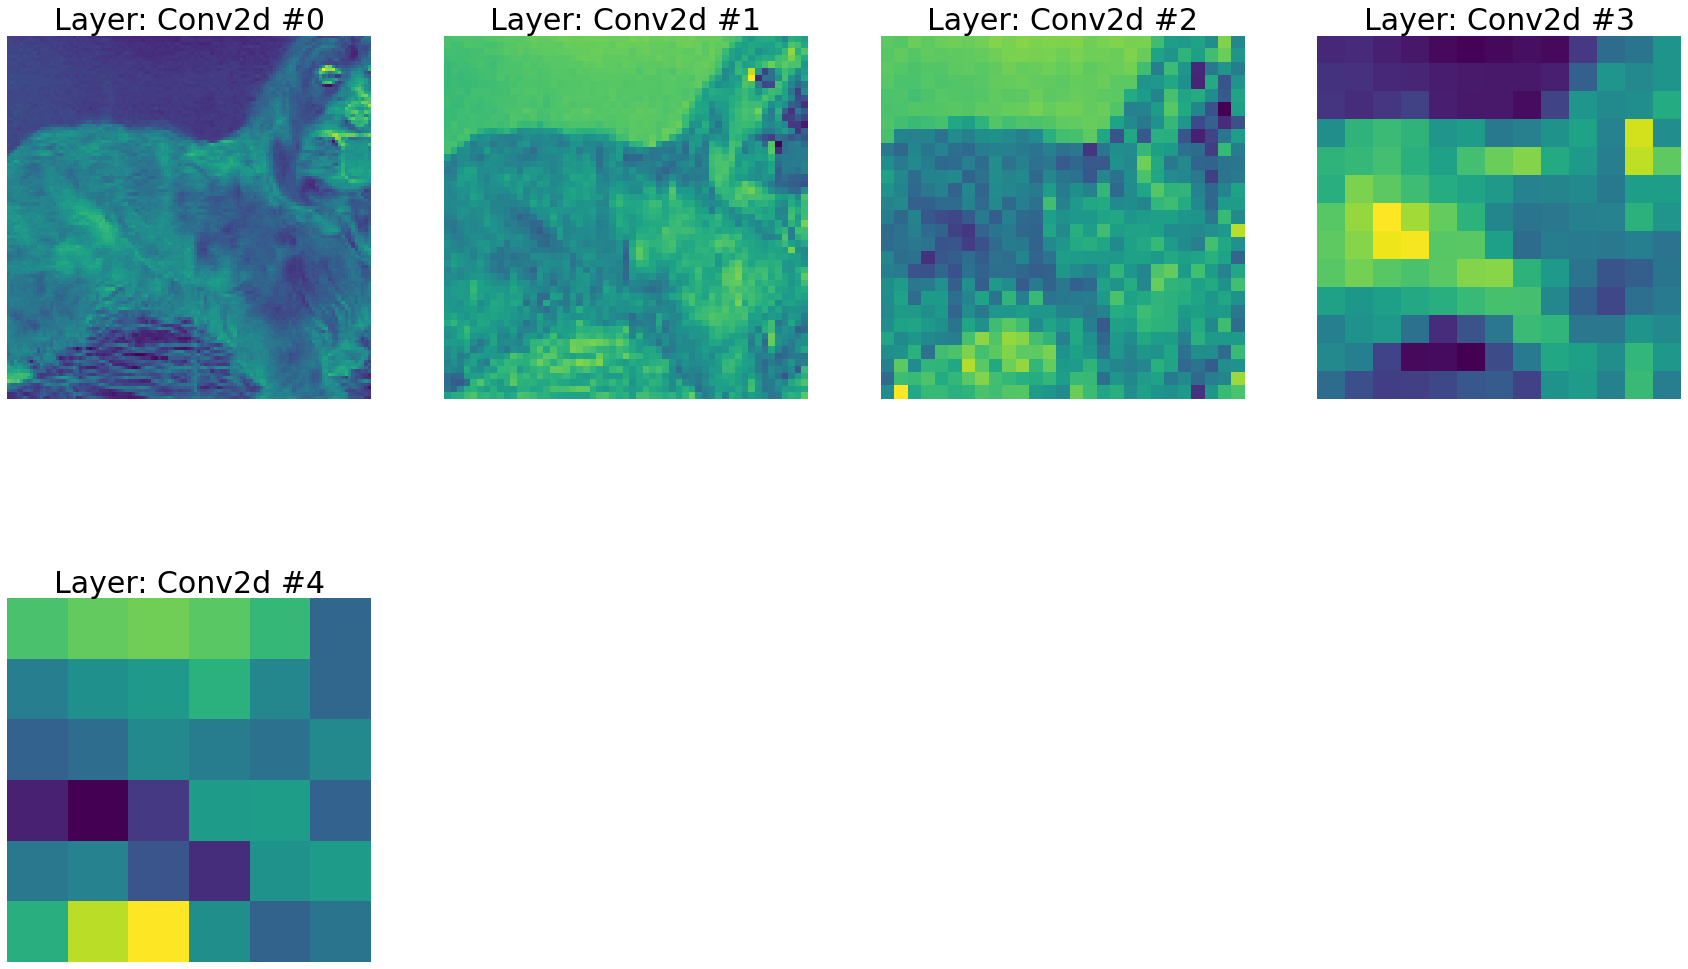

In [98]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    #a.set_title(f"Layer: {i} {names[i].split('(')[0]}", fontsize=30)
    a.set_title(f"Layer: Conv2d #{i}", fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')